In [ ]:
pip install -U git+https://github.com/qubvel/segmentation_models.pytorch

In [ ]:
pip install rasterio

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

In [2]:
from pathlib import Path

from tqdm import tqdm

import sys, os, random, time, json
import numba, cv2, gc
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D

import torchvision
from torchvision import transforms as T

from segmentation_models_pytorch import FPN
from segmentation_models_pytorch import Unet
from segmentation_models_pytorch import MAnet
from segmentation_models_pytorch import Linknet
from segmentation_models_pytorch import PAN
import segmentation_models_pytorch as smp

import rasterio
from rasterio.windows import Window

import albumentations as A

import matplotlib.pyplot as plt

from sklearn.model_selection import GroupKFold

%matplotlib inline

In [3]:
def set_seeds(seed = 42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    
set_seeds()

### Setup training variables

In [4]:
!mkdir -p /home/jupyter/data/
DATA_PATH = Path('/home/jupyter/data_2/')
assert DATA_PATH.exists()

In [5]:
REPORT_PATH = Path('/home/jupyter/reports')
if not REPORT_PATH.exists():
    os.makedirs(REPORT_PATH)
assert REPORT_PATH.exists()

In [6]:
!ls {REPORT_PATH}

37_pytorch_fpn_efficientnet_b7_1536_768_shifted_slices_groupkfold_smooth_fold_0
37_pytorch_fpn_efficientnet_b7_1536_768_shifted_slices_groupkfold_smooth_fold_1
37_pytorch_fpn_efficientnet_b7_1536_768_shifted_slices_groupkfold_smooth_fold_2
37_pytorch_fpn_efficientnet_b7_1536_768_shifted_slices_groupkfold_smooth_fold_3
37_pytorch_fpn_efficientnet_b7_1536_768_shifted_slices_groupkfold_smooth_new_data_fold_0
37_pytorch_fpn_efficientnet_b7_1536_768_shifted_slices_groupkfold_smooth_new_data_fold_1
37_pytorch_fpn_efficientnet_b7_1536_768_shifted_slices_groupkfold_smooth_new_data_fold_2
37_pytorch_fpn_efficientnet_b7_1536_768_shifted_slices_groupkfold_smooth_new_data_fold_3
39_pytorch_fpn_efficientnet_b7_1536_768_shifted_slices_groupkfold_smooth_new_data_advprop_fold_0
39_pytorch_fpn_efficientnet_b7_1536_768_shifted_slices_groupkfold_smooth_new_data_advprop_fold_1
39_pytorch_fpn_efficientnet_b7_1536_768_shifted_slices_groupkfold_smooth_new_data_advprop_fold_2
39_pytorch_fpn_efficientnet_b7_15

In [15]:
ARCH = 'linknet' # fpn, manet, linknet, pan
EXPERIMENT_NAME = f'40_pytorch_{ARCH}_efficientnet_b7_1536_768_shifted_slices_groupkfold_smooth_new_data'

WINDOW = 1536 # tile size
MIN_OVERLAP = 64
NEW_SIZE = 768 # size after re-size which are fed to the model
THRESHOLD = 0
CONTENT_THRESHOLD = 0.001
NUM_WORKERS = 6

FOLDS = 4

BATCH_SIZE = 8
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

ENCODER_NAME = 'efficientnet-b6'

LR = 1e-3
WD = 1e-3
LABEL_SMOOTH = 0.01
GRAD_ACCU_STEPS = 1
BEST_MODEL = f'best_model_{ARCH}_efficientnetb7_1536_768_double_shift_{ENCODER_NAME}.pth'

RESET_IMAGES = True
ENCODER_WEIGHTS = 'imagenet'

In [16]:
def rle_decode(mask_rle, shape=(256, 256)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    splits = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (splits[0:][::2], splits[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype='uint8')
    for lo, hi in zip(starts, ends):
        img[lo: hi] = 1
    return img.reshape(shape, order='F') # Fortran order reshaping

In [17]:
@numba.njit()
def rle_numba(pixels):
    size = len(pixels)
    points = []
    if pixels[0] == 1: points.append(1)
    for i in range(1, size):
        if pixels[i] != pixels[i-1]:
            if len(points) % 2 == 0:
                points.append(i+1)
            else:
                points.append(i+1 - points[-1])
    if pixels[-1] == 1: points.append(size-points[-1]+1)    
    return points

In [18]:
# Check run length encoding starting with 0
assert rle_numba([0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1]) == [2, 2, 5, 1, 7, 4, 12, 1]
# Check run length encoding starting with 0
assert rle_numba([1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1]) == [1, 3, 5, 1, 7, 4, 12, 1]

In [19]:
def rle_numba_encode(image):
    pixels = image.flatten(order = 'F')
    points = rle_numba(pixels)
    return ' '.join(str(x) for x in points)

def make_grid(shape, window=256, min_overlap=32):
    """
        Return Array of size (N,4), where N - number of tiles,
        2nd axis represente slices: x1,x2,y1,y2 
    """
    x, y = shape
    nx = x // (window - min_overlap) + 1
    x1 = np.linspace(0, x, num=nx, endpoint=False, dtype=np.int64)
    x1[-1] = x - window
    x2 = (x1 + window).clip(0, x)
    ny = y // (window - min_overlap) + 1
    y1 = np.linspace(0, y, num=ny, endpoint=False, dtype=np.int64)
    y1[-1] = y - window
    y2 = (y1 + window).clip(0, y)
    slices = np.zeros((nx,ny, 4), dtype=np.int64)
    
    for i in range(nx):
        for j in range(ny):
            slices[i,j] = x1[i], x2[i], y1[j], y2[j]    
    return slices.reshape(nx*ny,4)

In [20]:
train_df = pd.read_csv(DATA_PATH / 'train.csv', index_col=[0])
train_df

encoding
id                                                          
2f6ecfcdf  296084587 4 296115835 6 296115859 14 296147109...
8242609fa  96909968 56 96941265 60 96972563 64 97003861 6...
aaa6a05cc  30989109 59 31007591 64 31026074 68 31044556 7...
cb2d976f4  78144363 5 78179297 15 78214231 25 78249165 35...
b9a3865fc  61271840 4 61303134 13 61334428 22 61365722 30...
b2dc8411c  56157731 21 56172571 45 56187411 51 56202252 5...
0486052bb  101676003 6 101701785 8 101727568 9 101753351 ...
e79de561c  7334642 14 7350821 41 7367001 67 7383180 82 73...
095bf7a1f  113277795 21 113315936 53 113354083 87 1133922...
54f2eec69  124967057 36 124997425 109 125027828 147 12505...
4ef6695ce  137041956 58 137081912 65 137121869 72 1371618...
26dc41664  245832956 28 245869925 2 245871115 33 24590808...
c68fe75ea  21256809 3 21283644 10 21310479 17 21337315 22...
afa5e8098  65837968 7 65874765 11 65874827 12 65911562 15...
1e2425f28  49453112 7 49479881 22 49506657 31 49533433 40...

In [21]:
MASK_PATH = Path('/home/jupyter/ds_cache')
!mkdir {MASK_PATH}

import shutil

def reset_mask_path():
    shutil.rmtree(MASK_PATH)

mkdir: cannot create directory ‘/home/jupyter/ds_cache’: File exists


### Dataset

In [22]:

# Used to filter tiles with enough color information in it
def is_tile_contains_info(img, pixel_limits = (50, 220), content_threshold = CONTENT_THRESHOLD, expected_shape = (WINDOW, WINDOW, 3)):
    """
    img: np.array
    pixel_limits: tuple
    content_threshold: float percents
    expected_shape: tuple
    """
    
    left_limit = np.prod(img > pixel_limits[0], axis=-1)
    right_limit =  np.prod(img < pixel_limits[1], axis=-1)

    if img.shape != expected_shape:
        print('img.shape != expected_shape', img.shape)
        return False, 0.

    percent_of_pixels = np.sum(left_limit*right_limit) / (img.shape[0] * img.shape[1])
    return  percent_of_pixels > content_threshold, percent_of_pixels

In [23]:
# identity = rasterio.Affine(1, 0, 0, 0, 1, 0)
identity = None
# normalize_transform = T.Normalize([0.625, 0.448, 0.688], [0.131, 0.177, 0.101])
# normalize_transform = T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# normalize_transform = T.Normalize([0.65459856,0.48386562,0.69428385], [0.15167958,0.23584107,0.13146145])
normalize_transform = T.Normalize([0.6276, 0.4468, 0.6769], [0.1446, 0.2113, 0.1233])

def read_from_slice(dataset, layers, x1, x2, y1, y2):
    if dataset.count == 3:
        image = dataset.read([1,2,3],
                    window=Window.from_slices((x1,x2),(y1,y2)))
        image = np.moveaxis(image, 0, -1)
    else:
        image = np.zeros((WINDOW, WINDOW, 3), dtype=np.uint8)
        for fl in range(3):
            image[:,:,fl] = layers[fl].read(window=Window.from_slices((x1,x2),(y1,y2)))
    return image.astype(np.uint8)

def extract_layers(dataset, filepath):
    layers = None
    if dataset.count != 3:
        layers = [rasterio.open(subd) for subd in dataset.subdatasets]
    return layers

In [24]:
if RESET_IMAGES:
    reset_mask_path()
    !mkdir {MASK_PATH}

In [25]:
class HubDataset(D.Dataset):
    def __init__(self, root_dir, transform, valid_transform=None, mode='train', window=WINDOW, overlap=MIN_OVERLAP, threshold = THRESHOLD):
        self.path = root_dir
        assert self.path.exists()
        self.overlap, self.window, self.transform, self.valid_transform, self.threshold = overlap, window, transform, valid_transform, threshold
        self.mode = mode
        self.csv = pd.read_csv(self.path / 'train.csv', index_col=[0])
        self.build_slices()
        self.len = len(self.slices)
        # where do these numbers come from?
        # Better to calculate them to check if correct.
        self.as_tensor = T.Compose([
            T.ToTensor(),
            normalize_transform,
        ])
        
    def __copy__(self):
        new_ds = type(self)(
            self.path,
            self.transform,
            valid_transform=self.valid_transform,
            mode=self.mode,
            window=self.window,
            overlap=self.overlap,
            threshold=self.threshold
        )
        new_ds.masks = self.masks
        new_ds.files = self.files
        new_ds.slices = self.slices
        new_ds.skipped = self.skipped
        return new_ds
    
    def build_masks(self):
        for i, filename in tqdm(enumerate(self.csv.index), total = len(self.csv)):
            filepath = self.path/'train'/f'{filename}.tiff'
            with rasterio.open(filepath) as dataset:
                self.masks.append(rle_decode(self.csv.loc[filename, 'encoding'], dataset.shape))
        
    def build_slices(self):
        self.masks = []; self.files = []; self.slices = []
        self.skipped = 0
        slices_path = MASK_PATH/f'slices.pkl'
        files_path = MASK_PATH/f'files.pkl'
        masks_path = MASK_PATH/f'masks.pkl'
        if not slices_path.exists():
            for i, filename in tqdm(enumerate(self.csv.index), total = len(self.csv)):
                filepath = self.path/'train'/f'{filename}.tiff'
                assert filepath.exists()
                self.files.append(filepath)
                with rasterio.open(filepath) as dataset:
                    self.build_slice(dataset, filename, i)
                print(f'Finished {filename}')
            with open(slices_path, "wb") as filehandler:
                pickle.dump(self.slices, filehandler)
            with open(files_path, "wb") as filehandler:
                pickle.dump(self.files, filehandler)
            
        else:
            print('Reading cached slices, files and masks')
            with open(slices_path,'rb') as file:
                self.slices = pickle.load(file)
            with open(files_path,'rb') as file:
                self.files = pickle.load(file)
        self.build_masks()
                
    def build_slice(self, dataset, filename, i):
        dataset_shape = dataset.shape
        self.masks.append(rle_decode(self.csv.loc[filename, 'encoding'], dataset_shape))
        slices = make_grid(dataset_shape, window = self.window, min_overlap = self.overlap)

        # Shifting slices to the right and bottom and adding to the original slices
        slices_copy = slices.copy()
        slices_copy_y = slices.copy()
#         # horizontal
        slices_copy[:,(0,1)] += WINDOW // 2 # shift
        slices = np.concatenate ([slices, slices_copy])
#         # vertical
        slices_copy_y[:,(2,3)] += WINDOW // 2
        slices = np.concatenate ([slices, slices_copy_y])
        slices = slices[~(slices[:,1] > dataset_shape[0]),:] # filter those outside of the screen
        slices = slices[~(slices[:,3] > dataset_shape[1]),:] # filter those outside of the screen
        
        layers = extract_layers(dataset, filename)
        
        # Only including slices above a specific threshold
        # Note: we are potentially throwing away some data here
        for slc in slices:
            x1, x2, y1, y2 = slc
            image = read_from_slice(dataset, layers, x1, x2 , y1, y2)
#             contains_info = is_tile_contains_info(image)
#             if self.masks[-1][x1:x2,y1:y2].sum() > self.threshold and contains_info[0]:
            if self.masks[-1][x1:x2,y1:y2].sum() > self.threshold:
                self.slices.append([i,x1,x2,y1,y2])
            else:
                self.skipped += 1
                        
                        
    def apply_transform(self, image, mask):
        augments = self.transform(image=image, mask=mask) if self.mode == 'train' else self.valid_transform(image=image, mask=mask)
        image = self.as_tensor(augments['image'])
        mask = augments['mask'][None]
        mask_torch = torch.from_numpy(mask).to(torch.float16)
        return image, mask_torch
        
    def __getitem__(self, index):
        image_path = MASK_PATH/f'image_{index}'
        mask_path = MASK_PATH/f'mask_{index}'
        if not image_path.exists():
            idx = self.slices[index][0]
            filename = self.files[idx]
            x1, x2, y1, y2 = self.slices[index][1:]
            with rasterio.open(filename) as dataset:
                layers = extract_layers(dataset, filename)
                image = read_from_slice(dataset, layers, x1, x2, y1, y2).astype('uint8')
            mask = self.masks[idx][x1:x2,y1:y2]
            with open(image_path, "wb") as filehandler:
                pickle.dump(image, filehandler)
                if index % 100 == 0:
                    print(f'Writing to {image_path}')
            with open(mask_path, "wb") as filehandler:
                pickle.dump(mask, filehandler)
            return self.apply_transform(image, mask)
        else:
            with open(image_path,'rb') as file:
                image = pickle.load(file)
            with open(mask_path,'rb') as file:
                mask = pickle.load(file)
            return self.apply_transform(image, mask)
    
    def __len__(self):
        return self.len
    
    def __repr__(self):
        return f'total: {len(self)}, skipped: {self.skipped} mode: {self.mode}'

In [26]:
def generate_ds(size):
    trfm = A.Compose([
        A.Resize(size, size, p=1.0),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.RandomRotate90(),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=20, p=0.9, 
                         border_mode=cv2.BORDER_CONSTANT),
        A.OneOf([
            A.OpticalDistortion(p=0.4),
            A.GridDistortion(p=.1, border_mode=cv2.BORDER_CONSTANT),
            A.IAAPiecewiseAffine(p=0.4),
        ], p=0.3),
        A.OneOf([
            A.HueSaturationValue(10,15,10),
            A.CLAHE(clip_limit=3),
            A.RandomBrightnessContrast(),            
        ], p=0.5)
    ], p=1.0)
    
    valid_transform = A.Compose([
        A.Resize(size, size, p=1.0),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.RandomRotate90()
    ])

    return HubDataset(DATA_PATH, window=WINDOW, overlap=MIN_OVERLAP, transform=trfm, valid_transform=valid_transform)

ds = generate_ds(NEW_SIZE)

  0%|          | 0/15 [00:00<?, ?it/s]/opt/conda/lib/python3.6/site-packages/rasterio/__init__.py:207: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
  7%|▋         | 1/15 [01:30<21:00, 90.03s/it]

Finished 2f6ecfcdf


 13%|█▎        | 2/15 [04:13<28:49, 133.07s/it]

Finished 8242609fa


 20%|██        | 3/15 [04:23<15:25, 77.11s/it] 

Finished aaa6a05cc


 27%|██▋       | 4/15 [07:39<22:44, 124.03s/it]

Finished cb2d976f4


 33%|███▎      | 5/15 [10:11<22:21, 134.20s/it]

Finished b9a3865fc


 40%|████      | 6/15 [10:31<14:17, 95.31s/it] 

Finished b2dc8411c


 47%|████▋     | 7/15 [12:12<12:55, 96.98s/it]

Finished 0486052bb


 53%|█████▎    | 8/15 [12:18<07:56, 68.05s/it]

Finished e79de561c


 60%|██████    | 9/15 [13:39<07:12, 72.16s/it]

Finished 095bf7a1f


 67%|██████▋   | 10/15 [13:58<04:38, 55.65s/it]

Finished 54f2eec69


 73%|███████▎  | 11/15 [15:56<04:58, 74.74s/it]

Finished 4ef6695ce


 87%|████████▋ | 13/15 [18:48<02:41, 80.93s/it]

Finished c68fe75ea


 93%|█████████▎| 14/15 [19:04<01:01, 61.07s/it]

Finished afa5e8098


  0%|          | 0/15 [00:00<?, ?it/s]

Finished 1e2425f28


100%|██████████| 15/15 [00:02<00:00,  5.08it/s]


In [27]:
ds

total: 7280, skipped: 16347 mode: train

In [28]:
# with rasterio.open('/home/jupyter/data/train/2f6ecfcdf.tiff') as raster:
#     img = raster.read([1,2,3], window=Window.from_slices((3909, 4933),(11464,12488)))
#     img = np.moveaxis(img, 0, -1)
#     print(img.shape)
#     crs = raster.crs

# plt.figure(figsize = (20,20))
# plt.imshow(img)
# plt.show()


In [29]:
# slices = make_grid(raster.shape, window = WINDOW, min_overlap = MIN_OVERLAP)
# slices.shape

In [30]:
# slices_copy_y = slices.copy()
# slices_copy_y[:,(2,3)] += WINDOW // 2
# slices_copy_y = slices_copy_y[~(slices_copy[:,3] > raster.shape[1]),:]
# slices = np.concatenate ([slices, slices_copy_y])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Writing to /home/jupyter/ds_cache/image_0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


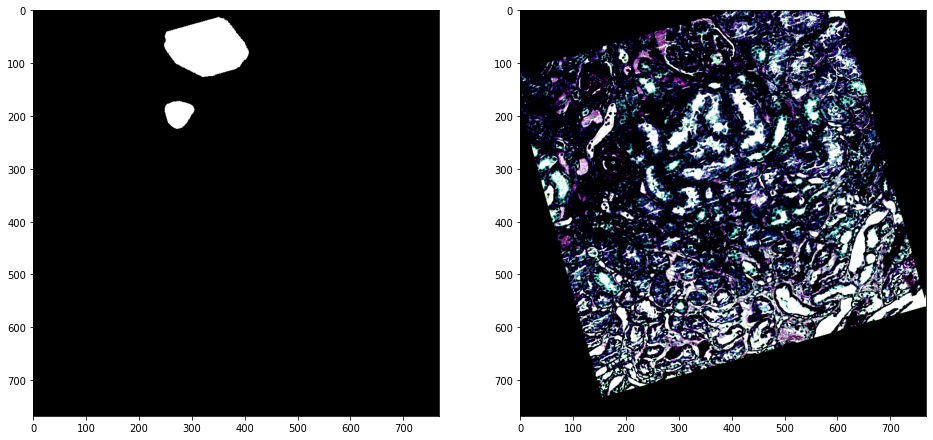

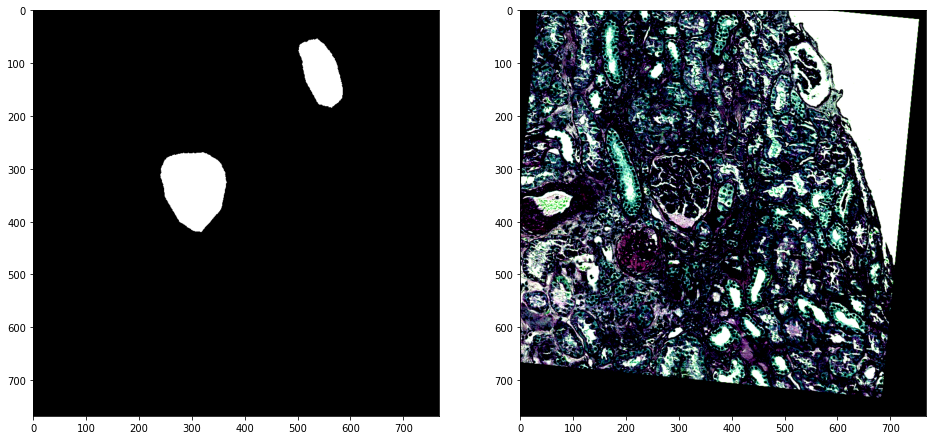

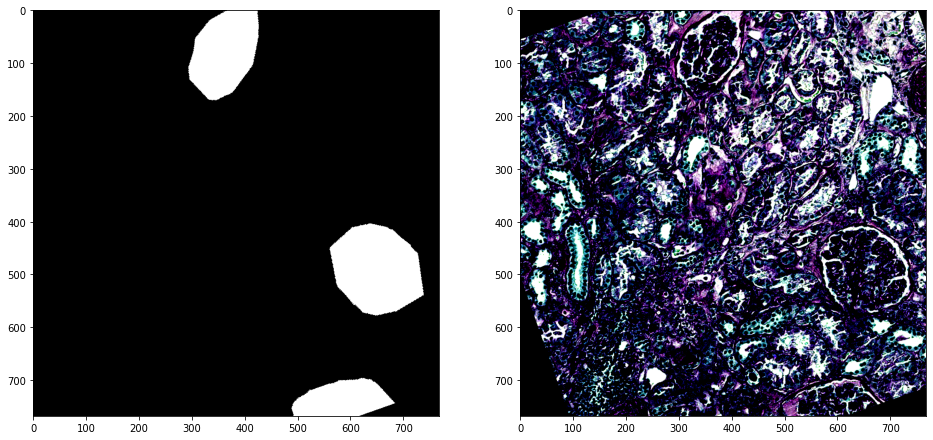

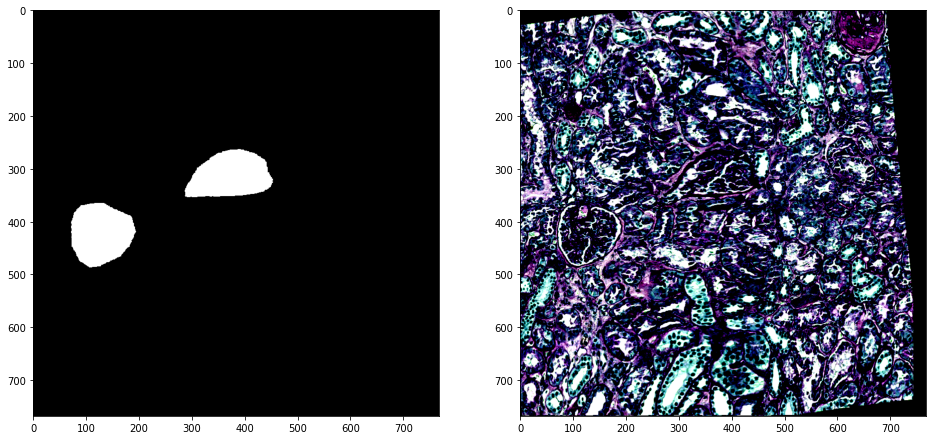

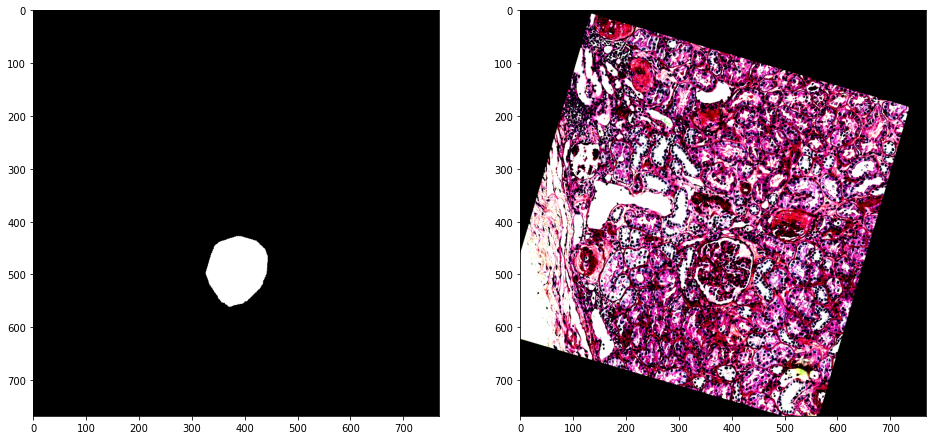

In [31]:
def display_mask_img(idx):
    image, mask = ds[idx]
    mask = mask.to(torch.uint8)
    plt.figure(figsize=(16,8))
    plt.subplot(121)
    plt.imshow(mask[0], cmap='gray')
    plt.subplot(122)
    plt.imshow(np.moveaxis(image.numpy(), 0, -1));

for i in range(5):
    display_mask_img(i)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


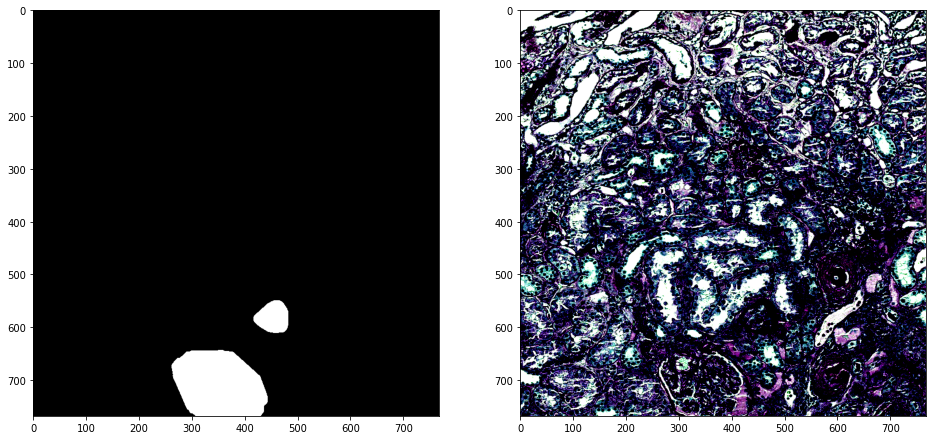

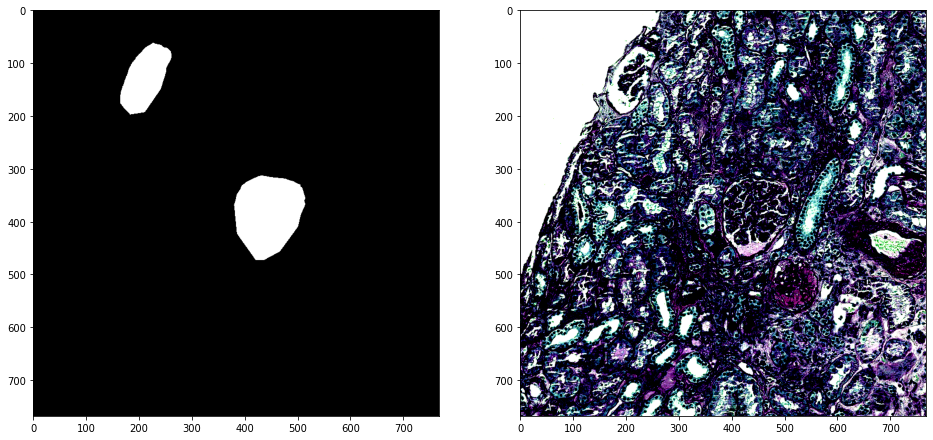

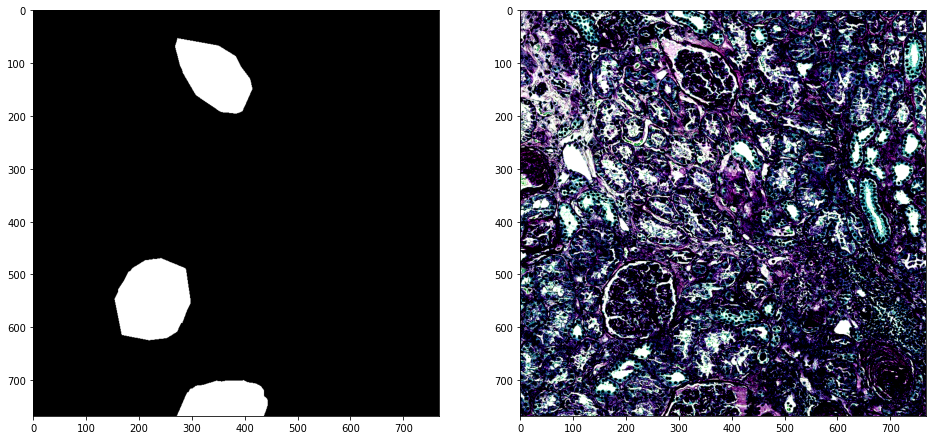

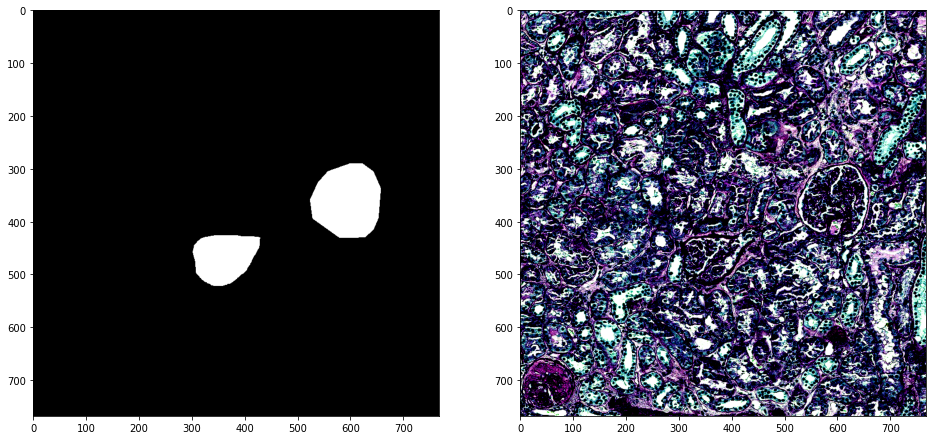

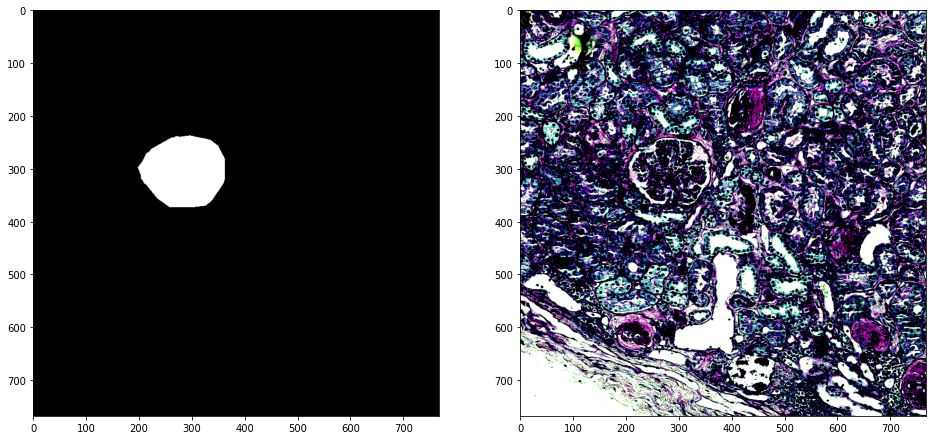

In [32]:
ds.mode = 'valid'

for i in range(5):
    display_mask_img(i)

In [33]:
ds.mode = 'train'

In [34]:
image, mask = ds[0]

_ = rle_numba_encode(mask[0].numpy().astype('uint8')) # compile function with numba

In [35]:
image.shape

torch.Size([3, 768, 768])

#### Split

In [36]:
# Images and its corresponding masks are saved with the same filename.
groups = [ds.slices[i][0] for i in range(len(ds))]

In [37]:
group_kfold = GroupKFold(n_splits = FOLDS)

#### Data loaders

In [38]:
import copy

def create_subset(ds, train_idx, valid_idx):
    train_ds = D.Subset(ds, train_idx)
    val_ds = copy.copy(ds)
    val_ds.mode = 'valid'
    valid_ds = D.Subset(val_ds, valid_idx)
    print(val_ds)
    return train_ds, valid_ds

In [39]:
def generate_train_valid_dls(ds, train_idx, valid_idx):
    train_ds, valid_ds = create_subset(ds, train_idx, valid_idx)

    num_workers = NUM_WORKERS
    # define training and validation data loaders
    train_dl = D.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers)

    valid_dl = D.DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)
    return train_dl, valid_dl

### Model

In [40]:
class HuBMAPModel(nn.Module):
    def __init__(self):
        super(HuBMAPModel, self).__init__()
        args = {
            'encoder_name': ENCODER_NAME, 
            'encoder_weights': ENCODER_WEIGHTS,
            'classes': 1,
            'activation': None,
            'aux_params': None
        }
        if ARCH == 'unet':
            self.model = Unet(**args)
        elif ARCH == 'fpn':
            self.model = FPN(**args)
        elif ARCH == 'manet':
            self.model = MAnet(**args)
        elif ARCH == 'linknet':
            self.model = Linknet(**args)
        elif ARCH == 'pan':
            self.model = PAN(**args)
        
    def forward(self, images):
        return self.model(images)

In [41]:
def get_model():
    model = HuBMAPModel()
    if torch.cuda.device_count() > 1:
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        model = nn.DataParallel(model)
    model.to(DEVICE)
    return model

### Training

In [42]:
def create_optimizer_scheduler(model, train_dl, epochs):
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WD)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR,
                                                    steps_per_epoch=len(train_dl), epochs=epochs)
    return optimizer, scheduler

### Loss

In [43]:
class SoftDiceLoss(nn.Module):
    def __init__(self, smooth=1., dims=(-2,-1)):

        super(SoftDiceLoss, self).__init__()
        self.smooth = smooth
        self.dims = dims
    
    def forward(self, x, y):

        tp = (x * y).sum(self.dims)
        fp = (x * (1 - y)).sum(self.dims)
        fn = ((1 - x) * y).sum(self.dims)
        
        dc = (2 * tp + self.smooth) / (2 * tp + fp + fn + self.smooth)
        dc = dc.mean()

        return 1 - dc
    
bce_fn = nn.BCEWithLogitsLoss()
dice_fn = SoftDiceLoss()

def loss_fn(y_pred, y_true):
    bce = bce_fn(y_pred, y_true)
    dice = dice_fn(y_pred.sigmoid(), y_true)
    return 0.5 * bce + 0.5 * dice

In [44]:
dice_loss = smp.losses.DiceLoss(mode='binary', from_logits=False)

def loss_fn(y_pred, y_true):
    return dice_loss(y_pred.sigmoid(), y_true)

In [45]:
LOSS_ALPHA = 0.4

def loss_fn(y_pred, y_true):
    return LOSS_ALPHA * dice_loss(y_pred.sigmoid(), y_true) + (1 - LOSS_ALPHA) * bce_fn(y_pred, y_true)

In [46]:
# jaccard_loss = smp.utils.losses.JaccardLoss()

# def loss_fn(y_pred, y_true):
#     return jaccard_loss(y_pred.sigmoid(), y_true)

In [47]:
def dice_metric(y_pred, y, epsilon = 1e-7):
    dims=(-2,-1)
    x = (y_pred > 0).float()
    dc = (2 * (x * y).sum(dims) + epsilon) / ((x + y).sum(dims) + epsilon)
    return dc.mean()

In [48]:
iou_metric = smp.utils.metrics.IoU(threshold=0.5)
dice_metric_2 = smp.utils.metrics.Fscore()

In [49]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
# def smooth_mask(mask, alpha = 0.9):
#     zeros_mask = (mask == 0).to(torch.float16) * (1 - alpha)
#     mask = mask * alpha
#     return mask + zeros_mask

def smooth_mask_2(mask, alpha = LABEL_SMOOTH):
    return (1 - alpha) * mask + alpha / 2

def train_epoch(model, dataloader, optim, criterion, scheduler, device="cpu", grad_accu_steps=GRAD_ACCU_STEPS):
    model.train()
    
    train_loss = []
    labels = []
    outs = []
    lrs = []
    
    tbar = tqdm(dataloader, position=0, leave=True)
    scaler = torch.cuda.amp.GradScaler() # mixed precision support
    scale = None
    for step, (image, target) in enumerate(tbar):
        image, target = image.to(DEVICE), target.float().to(DEVICE)
        target = smooth_mask_2(target)
        
        with torch.cuda.amp.autocast():
            output = model(image)
            loss = criterion(output, target) / grad_accu_steps
        
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        if (step + 1) % grad_accu_steps == 0:
            scaler.step(optim)
            scale = scaler.get_scale()
            scaler.update()
            optim.zero_grad()
        
        skip_lr_sched = (scale != scaler.get_scale())
        if not skip_lr_sched:
            scheduler.step()
        
        loss_val = loss.item() * grad_accu_steps
        train_loss.append(loss_val)
        lrs.append(get_lr(optim))
        
        tbar.set_description('loss - {:.4f}'.format(loss_val))
        
    print(f'Train loss: {np.array(train_loss).mean()}')
    return train_loss, lrs

In [50]:
all_metrics = [dice_metric, dice_metric_2, iou_metric]

def val_epoch(model, dataloader, criterion, epoch, device="cpu"):
    model.eval()

    valid_loss = []
    num_corrects = 0
    num_total = 0
    labels = []
    outs = []
    metric_list = [[] for _ in all_metrics]

    for item in dataloader:
        image, target = item
        image, target = image.to(DEVICE), target.float().to(DEVICE)

        with torch.no_grad():
            output = model(image)
            loss = criterion(output, target)
            for ml, m in zip(metric_list, all_metrics):
                ml.append(m(output, target).item())
        valid_loss.append(loss.item())

    avg_loss = np.array(valid_loss).mean()
    print(f'Epoch {epoch} - valid loss: {avg_loss}')
    dice_metric_mean = np.array(metric_list[0]).mean()
    dice_metric_mean_2 = np.array(metric_list[1]).mean()
    iou_metric_mean = np.array(metric_list[2]).mean()
    return valid_loss, dice_metric_mean, avg_loss, iou_metric_mean, dice_metric_mean_2

In [51]:
def train(fold, epochs, train_dl, valid_dl, optimizer, scheduler, patience = 6):
    best_loss = 100.0
    best_metric = 0
    train_losses = []
    valid_losses = []
    accumulated_lrs = []
    accumulated_dice_metrics = []
    early_stop_counter = 0
    messages = []

    for epoch in tqdm(range(epochs), position=0, leave=True):
        train_loss, lrs = train_epoch(model, train_dl, optimizer, loss_fn, scheduler, DEVICE)
        valid_loss, dice_metric_mean, avg_loss, iou_metric_mean, dice_metric_mean_2 = val_epoch(model, valid_dl, loss_fn, epoch, DEVICE)
        train_losses += train_loss
        valid_losses.append(np.array(valid_loss).mean())
        accumulated_lrs += lrs
        accumulated_dice_metrics.append(dice_metric_mean)
        if best_metric < dice_metric_mean:
            best_metric = dice_metric_mean
            print('Saving model')
            torch.save(model.state_dict(), BEST_MODEL)
            early_stop_counter = 0
        else:
            early_stop_counter += 1
        if best_loss > avg_loss:
            best_loss = avg_loss
        print(f'Epoch {epoch} - val best loss {best_loss} dice metric ({dice_metric_mean}, {dice_metric_mean_2}) iou metric ({iou_metric_mean}).')
        messages.append({
            'fold': fold,
            'epoch': epoch,
            'best_loss': best_loss,
            'dice_metric_mean': dice_metric_mean,
            'dice_coeff_mean': dice_metric_mean_2,
            'iou_metric_mean': iou_metric_mean
        })
        with open(REPORT_PATH/f'{EXPERIMENT_NAME}_fold_{fold}', 'w') as outfile:
            json.dump(messages, outfile)
        if early_stop_counter >= patience:
            print('Stopping early')
            break
    
    return train_losses, valid_losses, accumulated_lrs, accumulated_dice_metrics

In [52]:
fold_info = [(train_idx, valid_idx) for fold, (train_idx, valid_idx) in tqdm(enumerate(group_kfold.split(ds.slices, 
                                                        groups = groups)), total=FOLDS)]

100%|██████████| 4/4 [00:00<00:00, 2066.41it/s]


In [53]:
# !rm sample_weights_model_efficientnet_b7.pth

In [54]:
EPOCHS = 15
PATIENCE = 5

In [55]:
def train_split(fold_info, fold):
    global model
    
    print(f'Processing fold {fold}')
    model = get_model()
    train_idx, valid_idx = fold_info[fold]
    print(f'Proportions valid / train: {len(valid_idx) / len(train_idx)}')
    train_dl, valid_dl = generate_train_valid_dls(ds, train_idx, valid_idx)
    optimizer, scheduler = create_optimizer_scheduler(model, train_dl, EPOCHS)
    train_losses, valid_losses, accumulated_lrs, accumulated_dice_metrics = train(fold, EPOCHS, train_dl, valid_dl, optimizer, scheduler, patience = PATIENCE)
    return train_losses, valid_losses, accumulated_lrs, accumulated_dice_metrics

In [56]:
# from fastai.data.core import DataLoaders

# train_idx, valid_idx = fold_info[0]
# train_ds, valid_ds = create_subset(ds, train_idx, valid_idx)

# dls = DataLoaders.from_dsets(train_ds, valid_ds, bs=BATCH_SIZE, num_workers=0)
# assert(dls.bs == BATCH_SIZE)

In [57]:
# model = get_model()
# metrics = [dice_metric, dice_metric_2, iou_metric]
# criterion = loss_fn

In [58]:
# from fastai.vision.all import Learner
# from fastai.callback.fp16 import *

# learn = Learner(dls, model, loss_func=criterion, lr=LR, metrics=metrics, cbs=[MixedPrecision])
# learn = learn.to_fp16()

In [59]:
# %%time

# learn.fit_one_cycle(EPOCHS)

In [60]:
# train_idx, valid_idx = fold_info[0]
# train_dl, valid_dl = generate_train_valid_dls(ds, train_idx, valid_idx)
# for image, target in tqdm(train_dl):
#     pass
# #     assert image.shape[0] > 1
# for image, target in tqdm(valid_dl):
#     pass
# #     assert image.shape[0] > 1

In [61]:
def train_split_and_move(fold_info, fold):
    train_losses, valid_losses, accumulated_lrs, accumulated_dice_metrics = train_split(fold_info, fold)
    !mv {BEST_MODEL} {fold}_{BEST_MODEL}
    stats_df = pd.DataFrame({'train_losses': train_losses, 'accumulated_lrs': accumulated_lrs})
    stats_df[['train_losses']].plot()
    val_stats_df = pd.DataFrame({'valid_losses': valid_losses})
    val_stats_df[['valid_losses']].plot()

Processing fold 0


  0%|          | 0/15 [00:00<?, ?it/s]

Proportions valid / train: 0.33382191278856727
Reading cached slices, files and masks


/opt/conda/lib/python3.6/site-packages/rasterio/__init__.py:207: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
  0%|          | 0/683 [00:00<?, ?it/s]

total: 7280, skipped: 16347 mode: valid


/opt/conda/lib/python3.6/site-packages/torch/functional.py:1242: UserWarning: torch.norm is deprecated and may be removed in a future PyTorch release. Use torch.linalg.norm instead.
  "torch.norm is deprecated and may be removed in a future PyTorch release. "
loss - 0.7403:   2%|▏         | 11/683 [00:18<12:14,  1.09s/it] 

Writing to /home/jupyter/ds_cache/image_4000


loss - 0.7353:   2%|▏         | 13/683 [00:19<11:18,  1.01s/it]

Writing to /home/jupyter/ds_cache/image_3900


loss - 0.7168:   4%|▍         | 29/683 [00:35<10:19,  1.06it/s]

Writing to /home/jupyter/ds_cache/image_1500


loss - 0.7264:   5%|▍         | 33/683 [00:39<10:39,  1.02it/s]

Writing to /home/jupyter/ds_cache/image_1600


loss - 0.7231:   5%|▌         | 35/683 [00:41<10:32,  1.02it/s]

Writing to /home/jupyter/ds_cache/image_400


loss - 0.6968:  12%|█▏        | 82/683 [01:27<10:02,  1.00s/it]

Writing to /home/jupyter/ds_cache/image_1300


loss - 0.7065:  12%|█▏        | 84/683 [01:29<10:06,  1.01s/it]

Writing to /home/jupyter/ds_cache/image_500


loss - 0.6915:  13%|█▎        | 91/683 [01:37<09:59,  1.01s/it]

Writing to /home/jupyter/ds_cache/image_3400


loss - 0.6968:  14%|█▍        | 96/683 [01:42<09:42,  1.01it/s]

Writing to /home/jupyter/ds_cache/image_3300


loss - 0.6856:  18%|█▊        | 126/683 [02:12<09:10,  1.01it/s]

Writing to /home/jupyter/ds_cache/image_900


loss - 0.6870:  19%|█▉        | 129/683 [02:15<09:37,  1.04s/it]

Writing to /home/jupyter/ds_cache/image_2200


loss - 0.6823:  24%|██▍       | 163/683 [02:48<08:29,  1.02it/s]

Writing to /home/jupyter/ds_cache/image_6000


loss - 0.6766:  24%|██▍       | 167/683 [02:52<08:21,  1.03it/s]

Writing to /home/jupyter/ds_cache/image_1900


loss - 0.6738:  25%|██▍       | 170/683 [02:55<08:10,  1.05it/s]

Writing to /home/jupyter/ds_cache/image_6700
Writing to /home/jupyter/ds_cache/image_6200


loss - 0.6745:  25%|██▌       | 172/683 [02:57<08:39,  1.02s/it]

Writing to /home/jupyter/ds_cache/image_3800


loss - 0.6574:  29%|██▉       | 197/683 [03:22<08:05,  1.00it/s]

Writing to /home/jupyter/ds_cache/image_1000


loss - 0.6607:  31%|███       | 211/683 [03:35<07:32,  1.04it/s]

Writing to /home/jupyter/ds_cache/image_6600


loss - 0.6437:  33%|███▎      | 227/683 [03:52<07:42,  1.01s/it]

Writing to /home/jupyter/ds_cache/image_700


loss - 0.6545:  34%|███▍      | 234/683 [03:58<07:22,  1.02it/s]

Writing to /home/jupyter/ds_cache/image_5700


loss - 0.6393:  37%|███▋      | 252/683 [04:17<07:49,  1.09s/it]

Writing to /home/jupyter/ds_cache/image_300


loss - 0.6454:  38%|███▊      | 258/683 [04:23<07:02,  1.01it/s]

Writing to /home/jupyter/ds_cache/image_5900


loss - 0.6441:  41%|████      | 277/683 [04:42<07:06,  1.05s/it]

Writing to /home/jupyter/ds_cache/image_6500


loss - 0.6285:  43%|████▎     | 296/683 [05:01<06:18,  1.02it/s]

Writing to /home/jupyter/ds_cache/image_3200


loss - 0.6242:  43%|████▎     | 297/683 [05:02<06:13,  1.03it/s]

Writing to /home/jupyter/ds_cache/image_2500


loss - 0.6237:  48%|████▊     | 327/683 [05:32<05:48,  1.02it/s]

Writing to /home/jupyter/ds_cache/image_1200


loss - 0.6070:  50%|████▉     | 340/683 [05:45<06:08,  1.08s/it]

Writing to /home/jupyter/ds_cache/image_5800


loss - 0.6034:  52%|█████▏    | 354/683 [05:59<05:30,  1.00s/it]

Writing to /home/jupyter/ds_cache/image_2300


loss - 0.5986:  54%|█████▍    | 372/683 [06:17<05:07,  1.01it/s]

Writing to /home/jupyter/ds_cache/image_800


loss - 0.5961:  56%|█████▋    | 385/683 [06:30<04:58,  1.00s/it]

Writing to /home/jupyter/ds_cache/image_3600
Writing to /home/jupyter/ds_cache/image_2000


loss - 0.5885:  58%|█████▊    | 394/683 [06:39<04:38,  1.04it/s]

Writing to /home/jupyter/ds_cache/image_4100


loss - 0.5956:  62%|██████▏   | 424/683 [07:09<04:30,  1.04s/it]

Writing to /home/jupyter/ds_cache/image_3100


loss - 0.5690:  67%|██████▋   | 461/683 [07:46<03:37,  1.02it/s]

Writing to /home/jupyter/ds_cache/image_3500


loss - 0.5715:  68%|██████▊   | 462/683 [07:47<03:36,  1.02it/s]

Writing to /home/jupyter/ds_cache/image_2800


loss - 0.5835:  69%|██████▉   | 473/683 [07:59<03:34,  1.02s/it]

Writing to /home/jupyter/ds_cache/image_2900


loss - 0.5552:  73%|███████▎  | 501/683 [08:26<02:58,  1.02it/s]

Writing to /home/jupyter/ds_cache/image_5600


loss - 0.5529:  74%|███████▎  | 503/683 [08:28<03:05,  1.03s/it]

Writing to /home/jupyter/ds_cache/image_4200
Writing to /home/jupyter/ds_cache/image_5400


loss - 0.5623:  74%|███████▍  | 506/683 [08:31<02:55,  1.01it/s]

Writing to /home/jupyter/ds_cache/image_2600


loss - 0.5527:  75%|███████▍  | 509/683 [08:34<02:56,  1.02s/it]

Writing to /home/jupyter/ds_cache/image_1400


loss - 0.5556:  75%|███████▌  | 513/683 [08:38<02:45,  1.03it/s]

Writing to /home/jupyter/ds_cache/image_5500


loss - 0.5640:  75%|███████▌  | 514/683 [08:39<02:43,  1.04it/s]

Writing to /home/jupyter/ds_cache/image_1100


loss - 0.5576:  77%|███████▋  | 525/683 [08:50<02:35,  1.02it/s]

Writing to /home/jupyter/ds_cache/image_3700


loss - 0.5517:  78%|███████▊  | 531/683 [08:56<02:26,  1.04it/s]

Writing to /home/jupyter/ds_cache/image_1800


loss - 0.5568:  79%|███████▉  | 538/683 [09:03<02:24,  1.00it/s]

Writing to /home/jupyter/ds_cache/image_2700


loss - 0.5417:  81%|████████▏ | 555/683 [09:19<02:03,  1.04it/s]

Writing to /home/jupyter/ds_cache/image_3000


loss - 0.5464:  84%|████████▍ | 574/683 [09:39<01:55,  1.06s/it]

Writing to /home/jupyter/ds_cache/image_6300


loss - 0.5360:  88%|████████▊ | 601/683 [10:06<01:22,  1.01s/it]

Writing to /home/jupyter/ds_cache/image_6400


loss - 0.5285:  88%|████████▊ | 603/683 [10:08<01:17,  1.03it/s]

Writing to /home/jupyter/ds_cache/image_6100


loss - 0.5222:  91%|█████████ | 622/683 [10:27<01:01,  1.01s/it]

Writing to /home/jupyter/ds_cache/image_2400


loss - 0.5175:  95%|█████████▍| 646/683 [10:51<00:37,  1.00s/it]

Writing to /home/jupyter/ds_cache/image_2100


loss - 0.5082:  96%|█████████▌| 653/683 [10:58<00:30,  1.01s/it]

Writing to /home/jupyter/ds_cache/image_600


loss - 0.5121:  96%|█████████▌| 655/683 [11:00<00:28,  1.03s/it]

Writing to /home/jupyter/ds_cache/image_1700


loss - 0.5047: 100%|██████████| 683/683 [11:28<00:00,  1.01s/it]

Train loss: 0.6148170994630147


Writing to /home/jupyter/ds_cache/image_100
Writing to /home/jupyter/ds_cache/image_200
Writing to /home/jupyter/ds_cache/image_4300
Writing to /home/jupyter/ds_cache/image_4400
Writing to /home/jupyter/ds_cache/image_4500
Writing to /home/jupyter/ds_cache/image_4600
Writing to /home/jupyter/ds_cache/image_4700
Writing to /home/jupyter/ds_cache/image_4800
Writing to /home/jupyter/ds_cache/image_4900
Writing to /home/jupyter/ds_cache/image_5000
Writing to /home/jupyter/ds_cache/image_5100
Writing to /home/jupyter/ds_cache/image_5200
Writing to /home/jupyter/ds_cache/image_5300
Writing to /home/jupyter/ds_cache/image_6800
Writing to /home/jupyter/ds_cache/image_6900
Writing to /home/jupyter/ds_cache/image_7000
Writing to /home/jupyter/ds_cache/image_7100
Writing to /home/jupyter/ds_cache/image_7200
Epoch 0 - valid loss: 0.5273345793809807
Saving model


  0%|          | 0/683 [00:00<?, ?it/s]89.20s/it]

Epoch 0 - val best loss 0.5273345793809807 dice metric (0.12568453774509722, 0.038335830483814344) iou metric (0.019572187664412093).


loss - 0.0764: 100%|██████████| 683/683 [11:00<00:00,  1.03it/s]

Train loss: 0.26902107250812635


Epoch 1 - valid loss: 0.07035157254390549
Saving model


  0%|          | 0/683 [00:00<?, ?it/s]71.33s/it]

Epoch 1 - val best loss 0.07035157254390549 dice metric (0.866122379899025, 0.924408475557963) iou metric (0.8603091940545199).


loss - 0.1127: 100%|██████████| 683/683 [10:58<00:00,  1.04it/s]

Train loss: 0.09168694338503554


Epoch 2 - valid loss: 0.0457149775731459
Saving model


  0%|          | 0/683 [00:00<?, ?it/s]64.37s/it]

Epoch 2 - val best loss 0.0457149775731459 dice metric (0.8854411877038186, 0.9385673325312766) iou metric (0.8848923849954939).


loss - 0.0739: 100%|██████████| 683/683 [10:59<00:00,  1.04it/s]

Train loss: 0.0840945326849971



  0%|          | 0/683 [00:00<?, ?it/s]61.69s/it]

Epoch 3 - valid loss: 0.04780574132312547
Epoch 3 - val best loss 0.0457149775731459 dice metric (0.8677538011157722, 0.9323885801591372) iou metric (0.8744265256743682).


loss - 0.0930: 100%|██████████| 683/683 [10:59<00:00,  1.04it/s]

Train loss: 0.08141903412333344



  0%|          | 0/683 [00:00<?, ?it/s] 759.89s/it]

Epoch 4 - valid loss: 0.04526976435526944
Epoch 4 - val best loss 0.04526976435526944 dice metric (0.8832324398191351, 0.9377613956468147) iou metric (0.8836449243520436).


loss - 0.0811: 100%|██████████| 683/683 [10:58<00:00,  1.04it/s]

Train loss: 0.0795308224758676


Epoch 5 - valid loss: 0.041177859456327404
Saving model


  0%|          | 0/683 [00:00<?, ?it/s] 758.87s/it]

Epoch 5 - val best loss 0.041177859456327404 dice metric (0.8939553439094309, 0.9425053240960104) iou metric (0.8920141712092516).


loss - 0.0622: 100%|██████████| 683/683 [10:57<00:00,  1.04it/s]

Train loss: 0.07694251250099297


Epoch 6 - valid loss: 0.04159697847800296
Saving model


  0%|          | 0/683 [00:00<?, ?it/s] 757.64s/it]

Epoch 6 - val best loss 0.041177859456327404 dice metric (0.8941789643283475, 0.9413410467013978) iou metric (0.8900282694059506).


loss - 0.0643: 100%|██████████| 683/683 [11:00<00:00,  1.03it/s]

Train loss: 0.07546611552946215



  0%|          | 0/683 [00:00<?, ?it/s] 757.72s/it]

Epoch 7 - valid loss: 0.0422359771797793
Epoch 7 - val best loss 0.041177859456327404 dice metric (0.8892210084095336, 0.9410954703364456) iou metric (0.8896297498753196).


loss - 0.0697: 100%|██████████| 683/683 [10:56<00:00,  1.04it/s]

Train loss: 0.07466033653602942



  0%|          | 0/683 [00:00<?, ?it/s] 756.56s/it]

Epoch 8 - valid loss: 0.04218255328177883
Epoch 8 - val best loss 0.041177859456327404 dice metric (0.8893439476950127, 0.9398430128369415) iou metric (0.8875245250630797).


loss - 0.0688: 100%|██████████| 683/683 [10:55<00:00,  1.04it/s]

Train loss: 0.07177286407478034



  0%|          | 0/683 [00:00<?, ?it/s], 755.37s/it]

Epoch 9 - valid loss: 0.042087398665516
Epoch 9 - val best loss 0.041177859456327404 dice metric (0.8894300970591997, 0.9409010585462838) iou metric (0.8894092573931343).


loss - 0.0757: 100%|██████████| 683/683 [10:55<00:00,  1.04it/s]

Train loss: 0.07031711799639385



  0%|          | 0/683 [00:00<?, ?it/s]754.55s/it]  

Epoch 10 - valid loss: 0.04210163483788308
Epoch 10 - val best loss 0.041177859456327404 dice metric (0.8932367905712965, 0.9422822006438908) iou metric (0.891879644833113).


loss - 0.0675: 100%|██████████| 683/683 [10:55<00:00,  1.04it/s]

Train loss: 0.06999323494721471


Epoch 11 - valid loss: 0.041875503172999935
Saving model


  0%|          | 0/683 [00:00<?, ?it/s]754.32s/it]

Epoch 11 - val best loss 0.041177859456327404 dice metric (0.8972460329532623, 0.9421336969785523) iou metric (0.8916221328994685).


loss - 0.0750: 100%|██████████| 683/683 [10:58<00:00,  1.04it/s]

Train loss: 0.0681802159663437



  0%|          | 0/683 [00:00<?, ?it/s]754.75s/it]

Epoch 12 - valid loss: 0.041385835502296686
Epoch 12 - val best loss 0.041177859456327404 dice metric (0.8931442831169095, 0.9432577394079744) iou metric (0.8935964855185726).


loss - 0.0608: 100%|██████████| 683/683 [11:04<00:00,  1.03it/s]

Train loss: 0.06791878201471066



  0%|          | 0/683 [00:00<?, ?it/s]756.86s/it]

Epoch 13 - valid loss: 0.04145228121789139
Epoch 13 - val best loss 0.041177859456327404 dice metric (0.8968519801110552, 0.9433437554459823) iou metric (0.8936914689185327).


loss - 0.0650: 100%|██████████| 683/683 [10:57<00:00,  1.04it/s]

Train loss: 0.06788257889635042



100%|██████████| 15/15 [3:09:34<00:00, 758.27s/it]

Epoch 14 - valid loss: 0.0410809024939673
Epoch 14 - val best loss 0.0410809024939673 dice metric (0.8970177322626114, 0.9435551935120633) iou metric (0.8940552755406028).


CPU times: user 2h 26min 30s, sys: 39min 27s, total: 3h 5min 58s
Wall time: 3h 9min 40s


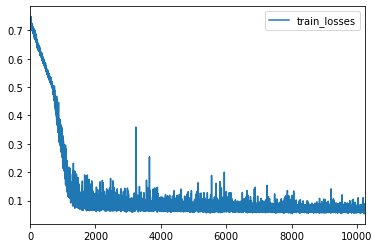

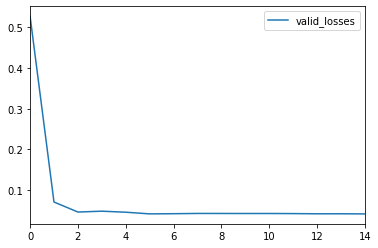

In [62]:
%%time
train_split_and_move(fold_info, 0)

Processing fold 1


  0%|          | 0/15 [00:00<?, ?it/s]

Proportions valid / train: 0.3323572474377745
Reading cached slices, files and masks


/opt/conda/lib/python3.6/site-packages/rasterio/__init__.py:207: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
  0%|          | 0/683 [00:00<?, ?it/s]

total: 7280, skipped: 16347 mode: valid


/opt/conda/lib/python3.6/site-packages/torch/functional.py:1242: UserWarning: torch.norm is deprecated and may be removed in a future PyTorch release. Use torch.linalg.norm instead.
  "torch.norm is deprecated and may be removed in a future PyTorch release. "
loss - 0.5524: 100%|██████████| 683/683 [10:58<00:00,  1.04it/s]

Train loss: 0.6958360564656348


Epoch 0 - valid loss: 0.5630937260678162
Saving model


  0%|          | 0/683 [00:00<?, ?it/s]55.39s/it]

Epoch 0 - val best loss 0.5630937260678162 dice metric (0.0006041383261662095, 2.5798573139159663e-08) iou metric (1.2899516287635305e-08).


loss - 0.1148: 100%|██████████| 683/683 [10:55<00:00,  1.04it/s]

Train loss: 0.3562473983532513


Epoch 1 - valid loss: 0.07751122543727774
Saving model


  0%|          | 0/683 [00:00<?, ?it/s]53.92s/it]

Epoch 1 - val best loss 0.07751122543727774 dice metric (0.8874410440743232, 0.9222983775685012) iou metric (0.8569452121919472).


loss - 0.1054: 100%|██████████| 683/683 [11:01<00:00,  1.03it/s]

Train loss: 0.09580938729674365


Epoch 2 - valid loss: 0.04310967537701655
Saving model


  0%|          | 0/683 [00:00<?, ?it/s]56.58s/it]

Epoch 2 - val best loss 0.04310967537701655 dice metric (0.912142622575886, 0.9427026150510175) iou metric (0.8922902768403949).


loss - 0.0692: 100%|██████████| 683/683 [11:00<00:00,  1.03it/s]

Train loss: 0.08534746277821012



  0%|          | 0/683 [00:00<?, ?it/s]57.20s/it]

Epoch 3 - valid loss: 0.04313930410415853
Epoch 3 - val best loss 0.04310967537701655 dice metric (0.9120253419035856, 0.9419227541805889) iou metric (0.890927753259432).


loss - 0.0835: 100%|██████████| 683/683 [10:59<00:00,  1.03it/s]

Train loss: 0.08290717771514095


Epoch 4 - valid loss: 0.03978300055218163
Saving model


  0%|          | 0/683 [00:00<?, ?it/s] 757.35s/it]

Epoch 4 - val best loss 0.03978300055218163 dice metric (0.9216070364225278, 0.9453313660516612) iou metric (0.8969191701401698).


loss - 0.0716: 100%|██████████| 683/683 [11:00<00:00,  1.03it/s]

Train loss: 0.08039180976972747



  0%|          | 0/683 [00:00<?, ?it/s] 757.48s/it]

Epoch 5 - valid loss: 0.04120513523563677
Epoch 5 - val best loss 0.03978300055218163 dice metric (0.9185361281890702, 0.9452576211895711) iou metric (0.896855505552586).


loss - 0.0686: 100%|██████████| 683/683 [11:00<00:00,  1.03it/s]

Train loss: 0.07874516543889988



  0%|          | 0/683 [00:00<?, ?it/s] 757.61s/it]

Epoch 6 - valid loss: 0.04499100105188754
Epoch 6 - val best loss 0.03978300055218163 dice metric (0.9027548968004235, 0.9363963493691667) iou metric (0.8814286594874008).


loss - 0.0765: 100%|██████████| 683/683 [11:03<00:00,  1.03it/s]

Train loss: 0.07686578251672349


Epoch 7 - valid loss: 0.03830397481894703
Saving model


  0%|          | 0/683 [00:00<?, ?it/s] 758.70s/it]

Epoch 7 - val best loss 0.03830397481894703 dice metric (0.9239087892523946, 0.947337687278109) iou metric (0.9005414334162741).


loss - 0.0743: 100%|██████████| 683/683 [11:00<00:00,  1.03it/s]

Train loss: 0.07470701904871976



  0%|          | 0/683 [00:00<?, ?it/s] 758.29s/it]

Epoch 8 - valid loss: 0.03959712327872342
Epoch 8 - val best loss 0.03830397481894703 dice metric (0.9206482219275924, 0.945361182815703) iou metric (0.8972190447840922).


loss - 0.0746:  40%|███▉      | 273/683 [04:28<06:53,  1.01s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

loss - 0.0642: 100%|██████████| 683/683 [11:00<00:00,  1.03it/s]

Train loss: 0.06900206472217425



  0%|          | 0/683 [00:00<?, ?it/s]756.79s/it]

Epoch 13 - valid loss: 0.03945872902312205
Epoch 13 - val best loss 0.03830397481894703 dice metric (0.9218289085421794, 0.9468312203096398) iou metric (0.8997636366520684).


loss - 0.0666: 100%|██████████| 683/683 [11:02<00:00,  1.03it/s]

Train loss: 0.06877477419062206



100%|██████████| 15/15 [3:09:19<00:00, 757.33s/it]

Epoch 14 - valid loss: 0.0389595075801737
Epoch 14 - val best loss 0.03830397481894703 dice metric (0.922191615934414, 0.9471930777448915) iou metric (0.9002701823931959).


CPU times: user 2h 26min 53s, sys: 39min 25s, total: 3h 6min 19s
Wall time: 3h 9min 24s


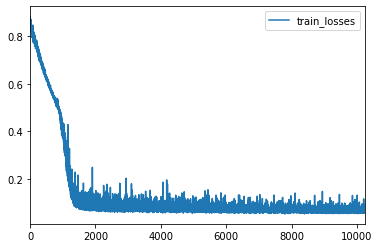

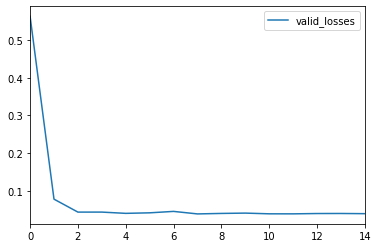

In [63]:
%%time
train_split_and_move(fold_info, 1)

Processing fold 2


  0%|          | 0/15 [00:00<?, ?it/s]

Proportions valid / train: 0.34045295525685876
Reading cached slices, files and masks


/opt/conda/lib/python3.6/site-packages/rasterio/__init__.py:207: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
  0%|          | 0/679 [00:00<?, ?it/s]

total: 7280, skipped: 16347 mode: valid


/opt/conda/lib/python3.6/site-packages/torch/functional.py:1242: UserWarning: torch.norm is deprecated and may be removed in a future PyTorch release. Use torch.linalg.norm instead.
  "torch.norm is deprecated and may be removed in a future PyTorch release. "
loss - 0.5465: 100%|██████████| 679/679 [10:55<00:00,  1.04it/s]

Train loss: 0.6707479506950491


Epoch 0 - valid loss: 0.5561248331234373
Saving model


  0%|          | 0/679 [00:00<?, ?it/s]55.04s/it]

Epoch 0 - val best loss 0.5561248331234373 dice metric (0.006026208264770748, 3.143163349474779e-06) iou metric (1.571591920221227e-06).


loss - 0.0996: 100%|██████████| 679/679 [10:57<00:00,  1.03it/s]

Train loss: 0.3321251241224153


Epoch 1 - valid loss: 0.08746490772042809
Saving model


  0%|          | 0/679 [00:00<?, ?it/s]55.98s/it]

Epoch 1 - val best loss 0.08746490772042809 dice metric (0.8434023953620987, 0.8988296212347481) iou metric (0.8282772674213228).


loss - 0.0818:  18%|█▊        | 124/679 [02:05<08:58,  1.03it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

loss - 0.0797: 100%|██████████| 679/679 [10:56<00:00,  1.03it/s]

Train loss: 0.07555312760426651



  0%|          | 0/679 [00:00<?, ?it/s] 754.66s/it]

Epoch 6 - valid loss: 0.062324854585438454
Epoch 6 - val best loss 0.06133812932490275 dice metric (0.8648424406760902, 0.9104482832140113) iou metric (0.8484864410270053).


loss - 0.0928: 100%|██████████| 679/679 [10:57<00:00,  1.03it/s]

Train loss: 0.07400120758013978



  0%|          | 0/679 [00:00<?, ?it/s] 755.28s/it]

Epoch 7 - valid loss: 0.061373164933496
Epoch 7 - val best loss 0.06133812932490275 dice metric (0.8641068023340632, 0.91381986875988) iou metric (0.8542370146847154).


loss - 0.0893:  85%|████████▌ | 579/679 [09:23<01:33,  1.07it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

loss - 0.0697: 100%|██████████| 679/679 [10:54<00:00,  1.04it/s]

Train loss: 0.06702437062524204



  0%|          | 0/679 [00:00<?, ?it/s]754.04s/it]

Epoch 13 - valid loss: 0.06074390597320322
Epoch 13 - val best loss 0.05967060461287098 dice metric (0.8750723861158071, 0.9145382507864948) iou metric (0.8555415125628146).


loss - 0.0603: 100%|██████████| 679/679 [10:54<00:00,  1.04it/s]

Train loss: 0.06702046159967583



100%|██████████| 15/15 [3:08:42<00:00, 754.81s/it]

Epoch 14 - valid loss: 0.06023092620106864
Epoch 14 - val best loss 0.05967060461287098 dice metric (0.8753100397258146, 0.9151865283733989) iou metric (0.8565277487425117).


CPU times: user 2h 26min 50s, sys: 39min 28s, total: 3h 6min 18s
Wall time: 3h 8min 47s


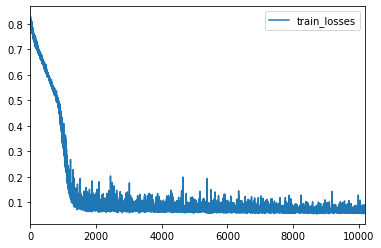

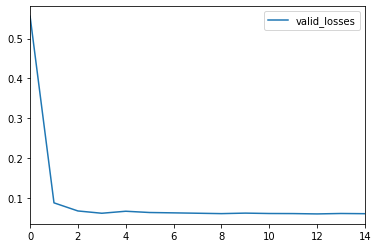

In [64]:
%%time
train_split_and_move(fold_info, 2)

Processing fold 3


  0%|          | 0/15 [00:00<?, ?it/s]

Proportions valid / train: 0.3267723710588664
Reading cached slices, files and masks


/opt/conda/lib/python3.6/site-packages/rasterio/__init__.py:207: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
  0%|          | 0/686 [00:00<?, ?it/s]

total: 7280, skipped: 16347 mode: valid


/opt/conda/lib/python3.6/site-packages/torch/functional.py:1242: UserWarning: torch.norm is deprecated and may be removed in a future PyTorch release. Use torch.linalg.norm instead.
  "torch.norm is deprecated and may be removed in a future PyTorch release. "
loss - 0.5489: 100%|██████████| 686/686 [10:57<00:00,  1.04it/s]

Train loss: 0.7023963929091529


Epoch 0 - valid loss: 0.5483503415849473
Saving model


  0%|          | 0/686 [00:00<?, ?it/s]54.15s/it]

Epoch 0 - val best loss 0.5483503415849473 dice metric (0.010373215446662571, 5.4057032033420635e-05) iou metric (2.7029950450241932e-05).


loss - 0.1604: 100%|██████████| 686/686 [11:01<00:00,  1.04it/s]

Train loss: 0.3493491741489217


Epoch 1 - valid loss: 0.08938980629046758
Saving model


  0%|          | 0/686 [00:00<?, ?it/s]56.74s/it]

Epoch 1 - val best loss 0.08938980629046758 dice metric (0.8590484926435682, 0.9016835596826341) iou metric (0.8281462507777744).


loss - 0.0915:  16%|█▌        | 110/686 [01:52<09:03,  1.06it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

loss - 0.0644: 100%|██████████| 686/686 [11:02<00:00,  1.04it/s]

Train loss: 0.07845374579614696


Epoch 6 - valid loss: 0.04527528581519922
Saving model


  0%|          | 0/686 [00:00<?, ?it/s] 757.90s/it]

Epoch 6 - val best loss 0.043890066428316964 dice metric (0.9074093651771545, 0.9387062978744507) iou metric (0.8867449023988512).


loss - 0.0764: 100%|██████████| 686/686 [11:02<00:00,  1.04it/s]

Train loss: 0.07569287169409737


Epoch 7 - valid loss: 0.04370476222700543
Saving model


  0%|          | 0/686 [00:00<?, ?it/s] 758.23s/it]

Epoch 7 - val best loss 0.04370476222700543 dice metric (0.9101078364584181, 0.9399989150630104) iou metric (0.8892019315560659).


loss - 0.0624:  57%|█████▋    | 394/686 [06:24<04:35,  1.06it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

loss - 0.0665: 100%|██████████| 686/686 [11:02<00:00,  1.04it/s]

Train loss: 0.06857276765450444


Epoch 13 - valid loss: 0.044424267146322464
Saving model


  0%|          | 0/686 [00:00<?, ?it/s]758.98s/it]

Epoch 13 - val best loss 0.04370476222700543 dice metric (0.9109689560201433, 0.9409475002023909) iou metric (0.8910044180022345).


loss - 0.0819: 100%|██████████| 686/686 [11:04<00:00,  1.03it/s]

Train loss: 0.06835392658916402


Epoch 14 - valid loss: 0.044645013668470915
Saving model


100%|██████████| 15/15 [3:09:39<00:00, 758.63s/it]

Epoch 14 - val best loss 0.04370476222700543 dice metric (0.9110492188400693, 0.9404027691152361) iou metric (0.8900520392921236).


CPU times: user 2h 27min 12s, sys: 39min 52s, total: 3h 7min 4s
Wall time: 3h 9min 44s


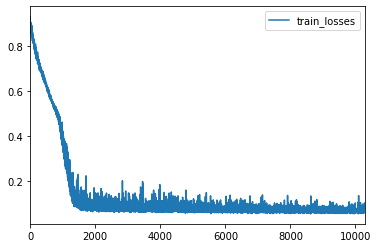

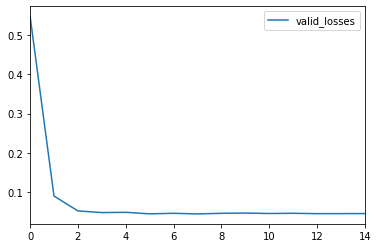

In [65]:
%%time
train_split_and_move(fold_info, 3)

In [ ]:
!mv *.pth models

In [ ]:
!ls